In [1]:
from oracles import Oracle
from optimization import *
import pandas as pd
import numpy as np
import cvxpy
from datetime import datetime
from xml.etree import ElementTree as ET
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [5]:
data = pd.read_csv('stocks_data.csv', delimiter=',')
data = data[1:-1]
data = data.loc[:, data.columns != 'Unnamed: 0']
data = data.fillna(0)

names = list(map(lambda x: x.split('.')[0], list(data.columns)))

In [6]:
len(names)

147

In [7]:
n_stocks = len(names)

In [8]:
incomes = np.array(data.values, dtype=np.float32)

In [9]:
mean_income = np.mean(incomes, axis=0)
covariance_income = np.cov(incomes.T)

In [10]:
solutions = []

for i in np.linspace(0, 0.03, 10):
    oracle = Oracle(Sigma=covariance_income, income=mean_income, lambda_1=i,rho=5, mode='efficient')
    solutions.append(AcceleratedProximalGD(oracle, x_0=np.random.uniform(size=len(mean_income)))[0])

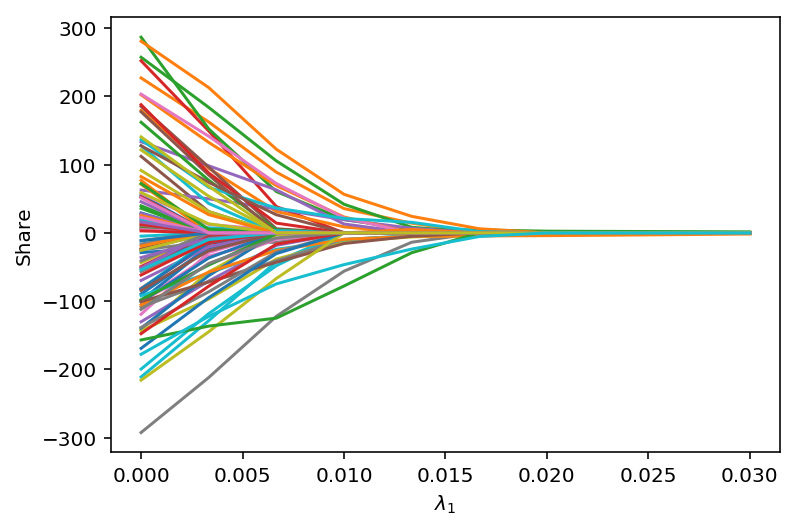

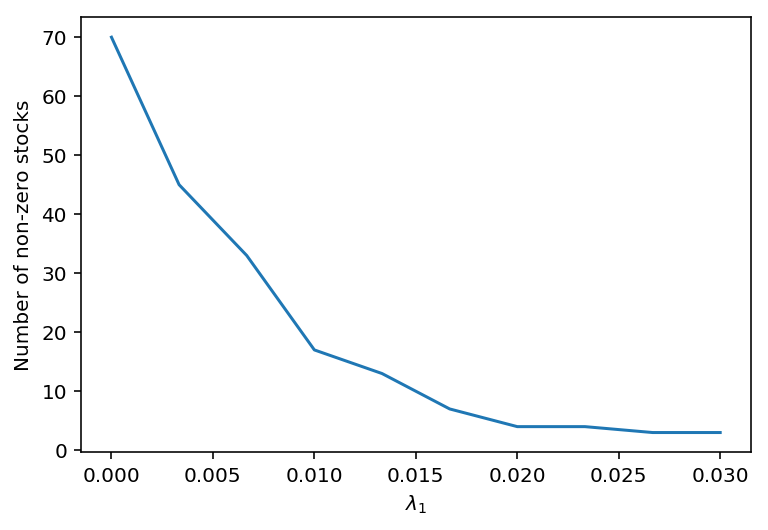

In [11]:
sef = np.array(solutions)

for i in range(100):
    plt.plot(np.linspace(0, 0.03, 10), sef[:, i])
plt.ylabel('Share')
plt.xlabel('$\lambda_1$')
plt.title('')
plt.show()


plt.plot(np.linspace(0, 0.03, 10), np.sum(sef > 1e-6, axis=1))
plt.ylabel('Number of non-zero stocks')
plt.xlabel('$\lambda_1$')
plt.show()

In [2]:
np.random.seed(4)

results_our = []
for i in range(5):
    ns = np.arange(10, 1000, 80)
    result_our = []
    for n in ns:
        diagonal = np.random.uniform(0, 10, n)
        b = np.random.normal(0,1, n)
        oracle = Oracle(Sigma=np.diag(diagonal), income=b, lambda_1=1, rho=5, mode='efficient')
        start_time = datetime.now()
        [x_star, msg, history] = AcceleratedProximalGD(oracle, np.zeros(n), trace=False, max_iter=100)
        result_our.append((datetime.now() - start_time).total_seconds())
        
    results_our.append(result_our)

In [3]:
np.random.seed(4)

results_cvx = []
for i in range(5):
    ns = np.arange(10, 1000, 80)
    result_cvx = []
    for n in ns:
        diagonal = np.random.uniform(0, 10, n)
        b = np.random.normal(0,1, n)
        
        x = cvxpy.Variable(n)
        obj = cvxpy.Minimize(cvxpy.quad_form(P=np.diag(diagonal), x=x)- 5 * x.T @ b + cvxpy.norm1(x))
        cons = [cvxpy.sum_entries(x) == 1]
        
        start_time = datetime.now()
        cvxpy.Problem(obj, cons).solve(solver='GUROBI')
        result_cvx.append((datetime.now() - start_time).total_seconds())
        
    results_cvx.append(result_cvx)

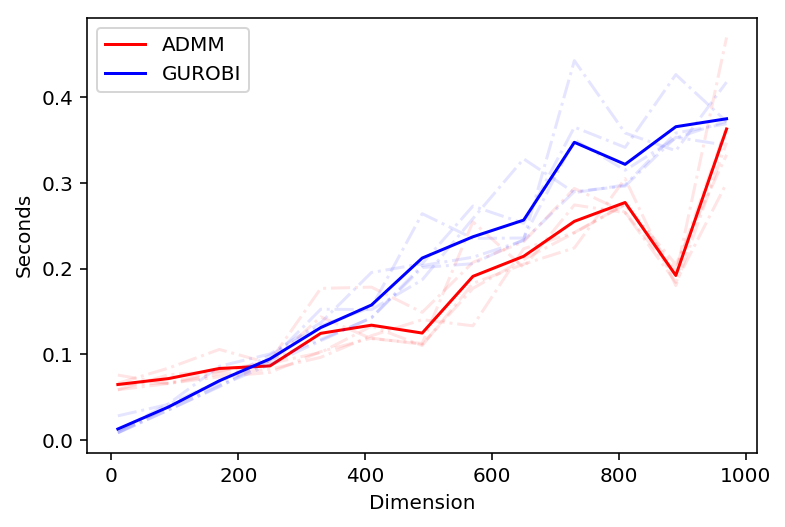

In [4]:
for result in results_our:
    plt.plot(ns, result, '-.', alpha=0.1, c='r')
plt.plot(ns, np.mean(results_our, axis=0), c='r', label='ADMM')

for result in results_cvx:
    plt.plot(ns, result, '-.', alpha=0.1, c='b')
    
plt.plot(ns, np.mean(results_cvx, axis=0), c='b', label='GUROBI')
plt.xlabel('Dimension')
plt.ylabel('Seconds')
plt.legend()
plt.show()